<a href="https://colab.research.google.com/github/Musa-Ali-Kazmi/Semantic-Segmentation-of-Slums-from-Satellite-Imagery-using-U-Net/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET Architecture

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handle padding issues
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# DiceScore

In [2]:
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    """
    Compute Dice Coefficient for binary segmentation.
    """
    # Ensure tensors have the same shape
    assert input.size() == target.size(), "Input and target must have the same shape"

    # Reshape tensors for batch operations
    if input.dim() == 4:  # If input has batch and channel dimensions (B, C, H, W)
        input = input.squeeze(1)  # Remove the channel dimension for binary segmentation
    if target.dim() == 4:  # If target has batch and channel dimensions
        target = target.squeeze(1)

    assert input.dim() == 3 or not reduce_batch_first, "Input must have 3 dimensions for batch reduction"

    # Compute Dice Coefficient
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)  # Intersection
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)  # Union
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)  # Handle empty sets

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)






# Dataset

In [11]:
import argparse
import logging
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

from torchvision import transforms as T
import random


In [4]:
class AirbusDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform = None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform

        # Exclude problematic file (e.g., tile_269.pt)
        self.tile_names = sorted(
            f.name for f in self.img_dir.glob('tile_*.pt')
        )

        # Ensure image and mask files match
        mask_tile_names = sorted(
            f.name for f in self.mask_dir.glob('tile_*.pt')
        )
        assert self.tile_names == mask_tile_names, "Mismatch between image and mask files!"

    def __len__(self):
        return len(self.tile_names)

    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        try:
            # Load image and mask
            image = torch.load(self.img_dir / tile_name, weights_only=True)
            mask = torch.load(self.mask_dir / tile_name, weights_only=True)

            # image = torch.load(self.img_dir / tile_name)  # Image tensor
            # mask = torch.load(self.mask_dir / tile_name)  # Mask tensor
        except (EOFError, RuntimeError) as e:
            # Log the error and skip the file
            print(f"Error loading {tile_name}: {e}")
            raise IndexError(f"Problem with file: {tile_name}")

        # Apply transformations if specified

        if self.transform:
            image = self.transform(image)
            image = (image - image.min()) / (image.max() - image.min())
            if random.random() > 0.5:
                image = T.functional.hflip(image)
                mask = T.functional.hflip(mask)
            if random.random() > 0.5:
                image = T.functional.vflip(image)
                mask = T.functional.vflip(mask)
            if random.random() > 0.5:
                random_angle = random.randint(-30, 30)
                image = T.functional.rotate(image, random_angle)
                mask = T.functional.rotate(mask, random_angle)

        return {'image': image, 'mask': mask}


# Training

In [ ]:
def train_model(
        model,
        device,
        img_dir,
        mask_dir,
        n_classes,
        epochs=5,
        batch_size=1,
        learning_rate=1e-5,
        val_percent=0.1,
        save_checkpoint=True,
        checkpoint_dir="/content/drive/MyDrive/FYP/UNet/checkpoints",
        amp=False,
):
    # Prepare dataset
    dataset = AirbusDataset(img_dir, mask_dir)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss() if n_classes == 1 else nn.CrossEntropyLoss()



    grad_scaler = torch.amp.GradScaler(enabled=amp)
    # grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    global_step = 0
    start_epoch = 1  # Default to start training from the first epoch

    # Check for existing checkpoints
    if os.path.exists(checkpoint_dir):
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
        if checkpoint_files:
            # Identify the checkpoint with the greatest epoch
            checkpoint_files.sort(key=lambda x: int(x.split('_epoch')[1].split('.pth')[0]), reverse=True)
            latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[0])

            print(f"Loading checkpoint from {latest_checkpoint}...")
            checkpoint = torch.load(latest_checkpoint, weights_only=True, map_location=device)
            # checkpoint = torch.load(latest_checkpoint, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            grad_scaler.load_state_dict(checkpoint['scaler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
            print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, start_epoch + epochs):
        model.train()
        epoch_loss = 0

        with tqdm(total=n_train, desc=f'Epoch {epoch}/{start_epoch + epochs - 1}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image'].to(device=device, dtype=torch.float32)
                true_masks = batch['mask'].to(device=device, dtype=torch.float32 if n_classes == 1 else torch.long)



                with torch.autocast(device.type, enabled=amp):
                    masks_pred = model(images)
                    if n_classes == 1:
                      masks_pred = torch.sigmoid(masks_pred)  # Convert logits to probabilities
                      loss = criterion(masks_pred, true_masks) + dice_loss(masks_pred, true_masks)
                    else:
                      loss = criterion(masks_pred, true_masks)


                # with torch.autocast(device.type, enabled=amp):
                #     masks_pred = model(images)
                #     if n_classes == 1:
                #         loss = criterion(masks_pred, true_masks) + dice_loss(torch.sigmoid(masks_pred), true_masks)
                #     else:
                #         loss = criterion(masks_pred, true_masks)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                global_step += 1
                pbar.set_postfix({'loss (batch)': loss.item()})

        val_score = evaluate(model, val_loader, device, amp, n_classes)
        logging.info(f'Validation Dice score: {val_score}')

        if save_checkpoint:
            Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f'unet_epoch{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': grad_scaler.state_dict()
            }, checkpoint_path)
            logging.info(f'Checkpoint saved for epoch {epoch}')



In [ ]:
def evaluate(model, loader, device, amp, n_classes):
    model.eval()
    dice_score = 0
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device=device, dtype=torch.float32)
            true_masks = batch['mask'].to(device=device, dtype=torch.float32 if n_classes == 1 else torch.long)

            with torch.autocast(device.type, enabled=amp):
                masks_pred = model(images)
                masks_pred = torch.sigmoid(masks_pred) if n_classes == 1 else F.softmax(masks_pred, dim=1)

            dice_score += dice_loss(masks_pred, true_masks, multiclass=n_classes > 1).item()

    return dice_score / len(loader)

In [ ]:
# def get_args():
#     parser = argparse.ArgumentParser(description='Train the UNet on Airbus images and masks')
#     parser.add_argument('--epochs', '-e', type=int, default=5, help='Number of epochs')
#     parser.add_argument('--batch-size', '-b', type=int, default=1, help='Batch size')
#     parser.add_argument('--learning-rate', '-l', type=float, default=1e-5, help='Learning rate')
#     parser.add_argument('--n-classes', '-c', type=int, required=True, help='Number of output classes')
#     parser.add_argument('--val', '-v', type=float, default=10.0, help='Validation data percentage')
#     parser.add_argument('--amp', action='store_true', help='Enable AMP for mixed precision training')
#     parser.add_argument('--device', '-d', type=str, default='cuda', help='Device to use (cuda or cpu)')
#     parser.add_argument('--img-dir', type=str, required=True, help='Path to Airbus image tiles')
#     parser.add_argument('--mask-dir', type=str, required=True, help='Path to Airbus mask tiles')
#     return parser.parse_args()

In [ ]:
# Main Script
if __name__ == '__main__':
    # Define parameters manually
    img_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/test/Images"
    mask_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/test/Masks"
    n_classes = 1
    epochs = 8
    batch_size = 4
    learning_rate = 1e-4
    val_percent = 15.0 / 100  # Convert to fraction
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    amp = False  # Enable mixed precision training if True

    # Initialize model
    model = UNet(n_channels=3, n_classes=n_classes, bilinear=True)
    model.to(device)

    # Start training
    train_model(
        model=model,
        device=device,
        img_dir=img_dir,
        mask_dir=mask_dir,
        n_classes=n_classes,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        val_percent=val_percent,
        amp=amp
    )



Using device: cuda
Loading checkpoint from /content/drive/MyDrive/FYP/UNet/checkpoints/unet_epoch32.pth...
Resuming training from epoch 33...


Epoch 40/41: 100%|██████████| 674/674 [00:27<00:00, 24.32img/s, loss (batch)=1.72]


# Training
## K-Fold Cross Validation

In [12]:
transforms = T.Compose([
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
        T.RandomAdjustSharpness(sharpness_factor=3, p=0.6),
        T.RandomAutocontrast(p=0.6),
        T.GaussianBlur(kernel_size=(5, 11), sigma=(0.1, 7)),
        T.RandomGrayscale(p=0.3),
        T.RandomInvert(p=0.2),
    ])

In [10]:
import torch

def evaluate(model, val_loader, device, amp, n_classes, threshold=0.5):
    """
    Evaluate the model on the validation set using Dice coefficient.

    Args:
        model: Trained UNet model.
        val_loader: DataLoader for the validation set.
        device: Device to run the model on.
        amp: Whether to use automatic mixed precision (AMP).
        n_classes: Number of output classes (1 for binary, >1 for multi-class).
        threshold: Threshold for binary classification.

    Returns:
        Average Dice coefficient over the validation set.
    """
    model.eval()  # Set model to evaluation mode
    total_dice_coeff = 0
    num_batches = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in val_loader:
            images = batch['image'].to(device, dtype=torch.float32)
            true_masks = batch['mask'].to(device, dtype=torch.float32 if n_classes == 1 else torch.long)

            # Generate predictions
            with torch.autocast(device_type=device.type, enabled=amp):
                masks_pred = model(images)

                if n_classes == 1:  # Binary segmentation
                    masks_pred = torch.sigmoid(masks_pred)  # Convert logits to probabilities
                    masks_pred = (masks_pred > threshold).float()  # Apply threshold

                else:  # Multi-class segmentation
                    masks_pred = torch.softmax(masks_pred, dim=1)
                    masks_pred = torch.argmax(masks_pred, dim=1)  # Get predicted class for each pixel

            # Compute Dice coefficient
            if n_classes == 1:
                dice = dice_coeff(masks_pred, true_masks, reduce_batch_first=True)
            else:
                dice = multiclass_dice_coeff(masks_pred, true_masks, reduce_batch_first=True)

            total_dice_coeff += dice.item()  # Accumulate Dice coefficient
            num_batches += 1

    # Compute average Dice coefficient over all validation batches
    return total_dice_coeff / num_batches


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import os
from pathlib import Path
import torch
import logging

def k_fold_cross_validation(
        model_class,
        dataset,
        device,
        n_classes,
        k_folds=5,
        epochs=5,
        batch_size=1,
        learning_rate=1e-5,
        save_checkpoint=True,
        checkpoint_dir="/content/drive/MyDrive/FYP/UNet/checkpoints",
        amp=False,
        val_metric="dice"  # Default validation metric
):
    """
    Implements K-Fold Cross-Validation for the UNet model.

    Args:
        model_class: Class of the model to instantiate for each fold.
        dataset: Complete dataset to split into folds.
        device: Device to train the model on (CPU or GPU).
        n_classes: Number of output classes.
        k_folds: Number of folds for cross-validation.
        epochs: Number of epochs to train in each fold.
        batch_size: Batch size for DataLoader.
        learning_rate: Learning rate for optimizer.
        save_checkpoint: Whether to save checkpoints.
        checkpoint_dir: Directory to save checkpoints.
        amp: Use Automatic Mixed Precision if True.
        val_metric: Metric to evaluate validation performance.

    Returns:
        None
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_results = []

    # Create directory for fold-specific checkpoints
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        logging.info(f"Starting Fold {fold + 1}/{k_folds}")

        # Create subsets for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
        train_loader = DataLoader(train_subset, shuffle=True, **loader_args)
        val_loader = DataLoader(val_subset, shuffle=False, drop_last=True, **loader_args)

        # Initialize model, optimizer, and loss
        model = model_class(n_channels=3, n_classes=n_classes, bilinear=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.BCEWithLogitsLoss() if n_classes == 1 else torch.nn.CrossEntropyLoss()
        grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

        best_val_metric = float('-inf')  # Track the best validation metric
        for epoch in range(1, epochs + 1):
            logging.info(f"Fold {fold + 1}, Epoch {epoch}/{epochs}")

            # Training loop
            model.train()
            epoch_loss = 0
            with tqdm(total=len(train_loader), desc=f"Epoch {epoch}", unit="batch") as pbar:
                for batch in train_loader:
                    images = batch['image'].to(device, dtype=torch.float32)
                    true_masks = batch['mask'].to(device, dtype=torch.float32 if n_classes == 1 else torch.long)

                    with torch.autocast(device_type=device.type, enabled=amp):
                        masks_pred = model(images)
                        loss = criterion(masks_pred, true_masks)
                        if n_classes == 1:
                            loss += dice_loss(torch.sigmoid(masks_pred), true_masks)

                    optimizer.zero_grad()
                    grad_scaler.scale(loss).backward()
                    grad_scaler.step(optimizer)
                    grad_scaler.update()

                    epoch_loss += loss.item()
                    pbar.update(1)
                    pbar.set_postfix({'Loss': loss.item()})

            # Validation
            val_score = evaluate(model, val_loader, device, amp, n_classes)
            logging.info(f"Fold {fold + 1}, Epoch {epoch}: Validation {val_metric.capitalize()} Score = {val_score:.4f}")

            # Save the best model for the fold
            if val_score > best_val_metric:
                best_val_metric = val_score
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"best_model_fold{fold + 1}.pth"))
                logging.info(f"Best model saved for Fold {fold + 1} at Epoch {epoch}")

        # Log fold result
        fold_results.append(best_val_metric)
        logging.info(f"Fold {fold + 1} completed. Best {val_metric.capitalize()} Score: {best_val_metric:.4f}")

    # Overall results
    mean_metric = sum(fold_results) / k_folds
    logging.info(f"K-Fold Cross Validation completed. Mean {val_metric.capitalize()} Score: {mean_metric:.4f}")


'''
Key Points
1. **`model_class` Parameter:** This allows reinitialization of the UNet model for each fold.
2. **Checkpoints Directory:** Saves the best model for each fold in `checkpoint_dir`.
3. **Loss Function:** Combines BCE/CrossEntropy and Dice loss for better segmentation performance.
4. **Metrics:** `evaluate` function should compute the desired validation metric (e.g., Dice score, IoU).
'''
### Example Usage

if __name__ == "__main__":
    img_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/test/Images"
    mask_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/test/Masks"
    dataset = AirbusDataset(img_dir, mask_dir, transforms)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    k_fold_cross_validation(
        model_class=UNet,
        dataset=dataset,
        device=device,
        n_classes=1,  # Binary segmentation
        k_folds=5,
        epochs=10,
        batch_size=4,
        learning_rate=1e-4,
        save_checkpoint=True,
        checkpoint_dir="/content/drive/MyDrive/FYP/UNet/KFold-checkpoints",
        amp=False
    )


<ipython-input-10-42a0687bac7e>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epoch 10: 100%|██████████| 159/159 [00:26<00:00,  6.05batch/s, Loss=1.07]


# Testing

In [5]:
from sklearn.metrics import jaccard_score, f1_score, precision_score

def calculate_metrics(predictions, targets, threshold=0.5):
    """
    Calculate IoU, F1 score, and precision for binary segmentation.

    Args:
        predictions: Predicted masks (batch_size, H, W).
        targets: Ground truth masks (batch_size, H, W).
        threshold: Threshold for binary segmentation.

    Returns:
        Tuple of (IoU, F1, Precision).
    """
    # Flatten predictions and targets
    predictions = predictions.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()

    # Apply threshold to predictions
    predictions = (predictions > threshold).astype(int)

    # Calculate metrics with zero_division parameter to handle undefined cases
    iou = jaccard_score(targets, predictions, average="binary", zero_division=0)
    f1 = f1_score(targets, predictions, average="binary", zero_division=0)
    precision = precision_score(targets, predictions, average="binary", zero_division=0)

    return iou, f1, precision


In [6]:

def test_model(model, test_loader, device, n_classes, threshold=0.5):
    """
    Test the model on a test set and compute IoU, F1 score, and precision.

    Args:
        model: Trained UNet model.
        test_loader: DataLoader for the test set.
        device: Device to run the model on.
        n_classes: Number of output classes (1 for binary, >1 for multiclass).
        threshold: Threshold for binary segmentation.

    Returns:
        Dictionary with mean IoU, F1 score, and precision.
    """
    model.eval()  # Set the model to evaluation mode
    total_iou, total_f1, total_precision = 0, 0, 0
    n_batches = len(test_loader)

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device=device, dtype=torch.float32)
            true_masks = batch['mask'].to(device=device, dtype=torch.float32 if n_classes == 1 else torch.long)

            # Generate predictions
            masks_pred = model(images)
            masks_pred = torch.sigmoid(masks_pred) if n_classes == 1 else F.softmax(masks_pred, dim=1)

            # Compute metrics for the batch
            batch_iou, batch_f1, batch_precision = calculate_metrics(masks_pred, true_masks, threshold)

            # Accumulate metrics
            total_iou += batch_iou
            total_f1 += batch_f1
            total_precision += batch_precision

    # Compute mean metrics
    mean_iou = total_iou / n_batches
    mean_f1 = total_f1 / n_batches
    mean_precision = total_precision / n_batches

    return {
        "Mean IoU": mean_iou,
        "Mean F1 Score": mean_f1,
        "Mean Precision": mean_precision
    }

In [9]:
# Test Script
if __name__ == '__main__':
    # Define test set parameters
    test_img_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/train/Images"
    test_mask_dir = "/content/drive/MyDrive/FYP/UNet/Airbus/train/Masks"
    batch_size = 4
    threshold = 0.5

    # Create the test dataset and loader
    test_dataset = AirbusDataset(test_img_dir, test_mask_dir)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load the trained model
    model = UNet(n_channels=3, n_classes=1, bilinear=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load the checkpoint
    checkpoint = torch.load('/content/drive/MyDrive/FYP/UNet/KFold-checkpoints/best_model_fold3.pth', weights_only=True, map_location=device)
    # checkpoint = torch.load('/content/drive/MyDrive/FYP/UNet/checkpoints/unet_epoch10.pth', map_location=device)

    # Load only the model's state dictionary
    # model.load_state_dict(checkpoint['model_state_dict'])
    model.load_state_dict(checkpoint)

    # model.load_state_dict(torch.load('/content/drive/MyDrive/FYP/UNet/checkpoints/unet_epoch10.pth'))  # Adjust the path to your checkpoint

    # Test the model
    metrics = test_model(model, test_loader, device, n_classes=1, threshold=threshold)

    # Print the results
    print("Test Results:")
    print(f"Mean IoU: {metrics['Mean IoU']:.4f}")
    print(f"Mean F1 Score: {metrics['Mean F1 Score']:.4f}")
    print(f"Mean Precision: {metrics['Mean Precision']:.4f}")


Test Results:
Mean IoU: 0.3023
Mean F1 Score: 0.3480
Mean Precision: 0.4326


# Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, device, num_samples=5, threshold=0.2):
    """
    Visualize predictions with thresholding.

    Args:
        model: Trained UNet model.
        dataset: Dataset object containing the images and masks.
        device: Device to run the model on.
        num_samples: Number of samples to visualize.
        threshold: Threshold for binary segmentation.
    """
    model.eval()  # Set the model to evaluation mode
    samples = np.random.choice(len(dataset), num_samples, replace=False)  # Randomly pick samples

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    axes = axes if num_samples > 1 else [axes]

    with torch.no_grad():
        for i, idx in enumerate(samples):
            data = dataset[idx]
            image = data['image'].unsqueeze(0).to(device)  # Add batch dimension and move to device
            target_mask = data['mask'].squeeze(0)  # Remove channel dimension

            # Generate prediction
            prediction = model(image)
            prediction = torch.sigmoid(prediction).squeeze(0).squeeze(0).cpu()

            # Apply thresholding
            prediction = (prediction > threshold).float()

            # Prepare the image for visualization
            img_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize for display

            # Display image, target mask, and predicted mask
            axes[i][0].imshow(img_np)
            axes[i][0].set_title("Input Image")
            axes[i][0].axis("off")

            axes[i][1].imshow(target_mask.cpu(), cmap="gray")
            axes[i][1].set_title("Target Mask")
            axes[i][1].axis("off")

            axes[i][2].imshow(prediction, cmap="gray")
            axes[i][2].set_title("Predicted Mask (Thresholded)")
            axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()





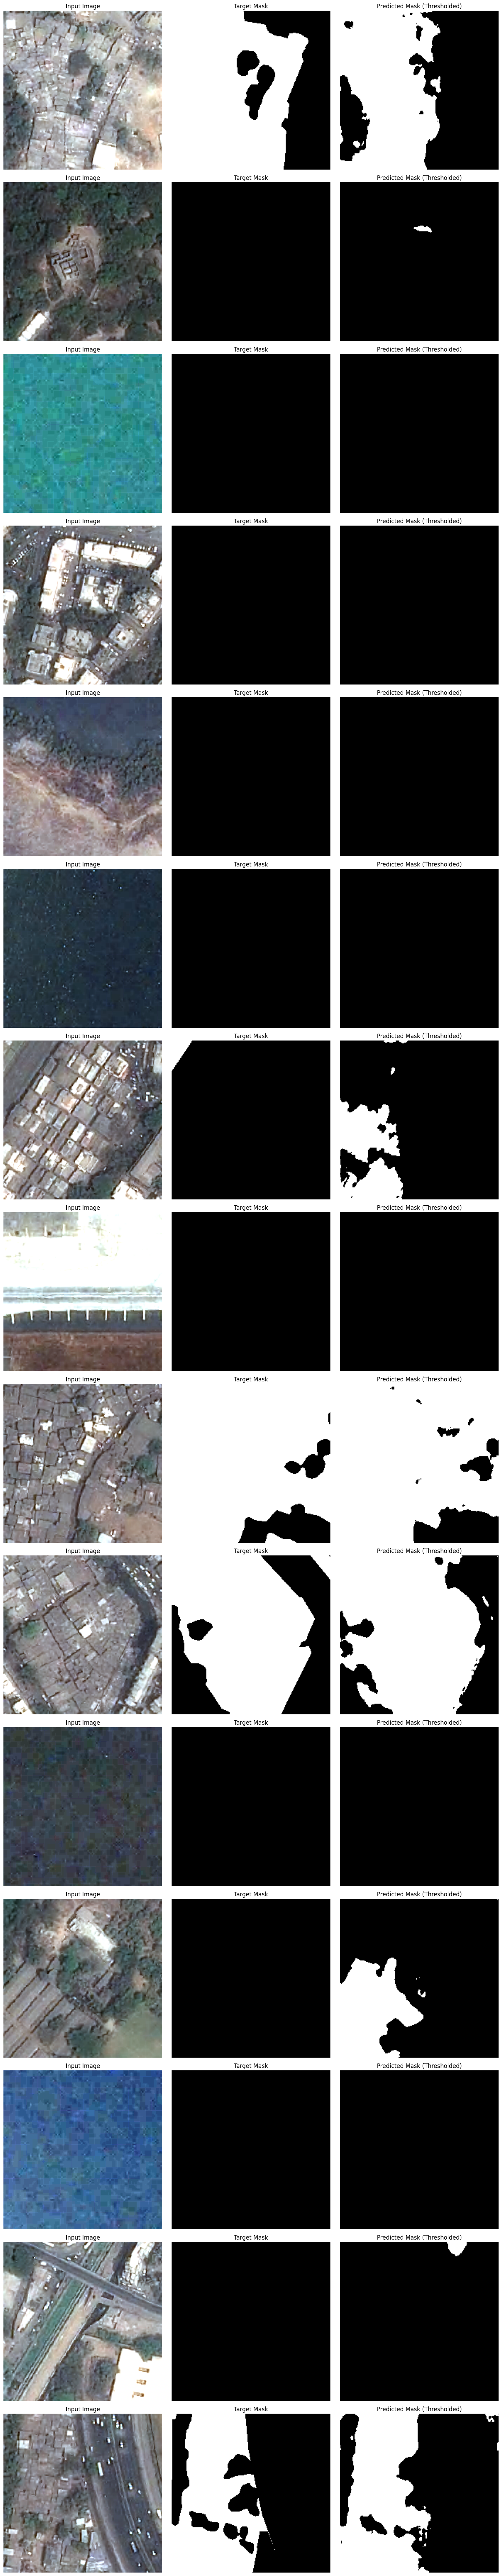

In [ ]:

dataset = AirbusDataset("/content/drive/MyDrive/FYP/UNet/NewSplits/Airbus/test/Images", "/content/drive/MyDrive/FYP/UNet/NewSplits/Airbus/test/Masks")
visualize_predictions(model, dataset, device, num_samples=15)


<ipython-input-4-8be6c79a00fc>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.img_dir / tile_name)  # Image tensor
<ipython-input-4-8be6c79a00fc>:

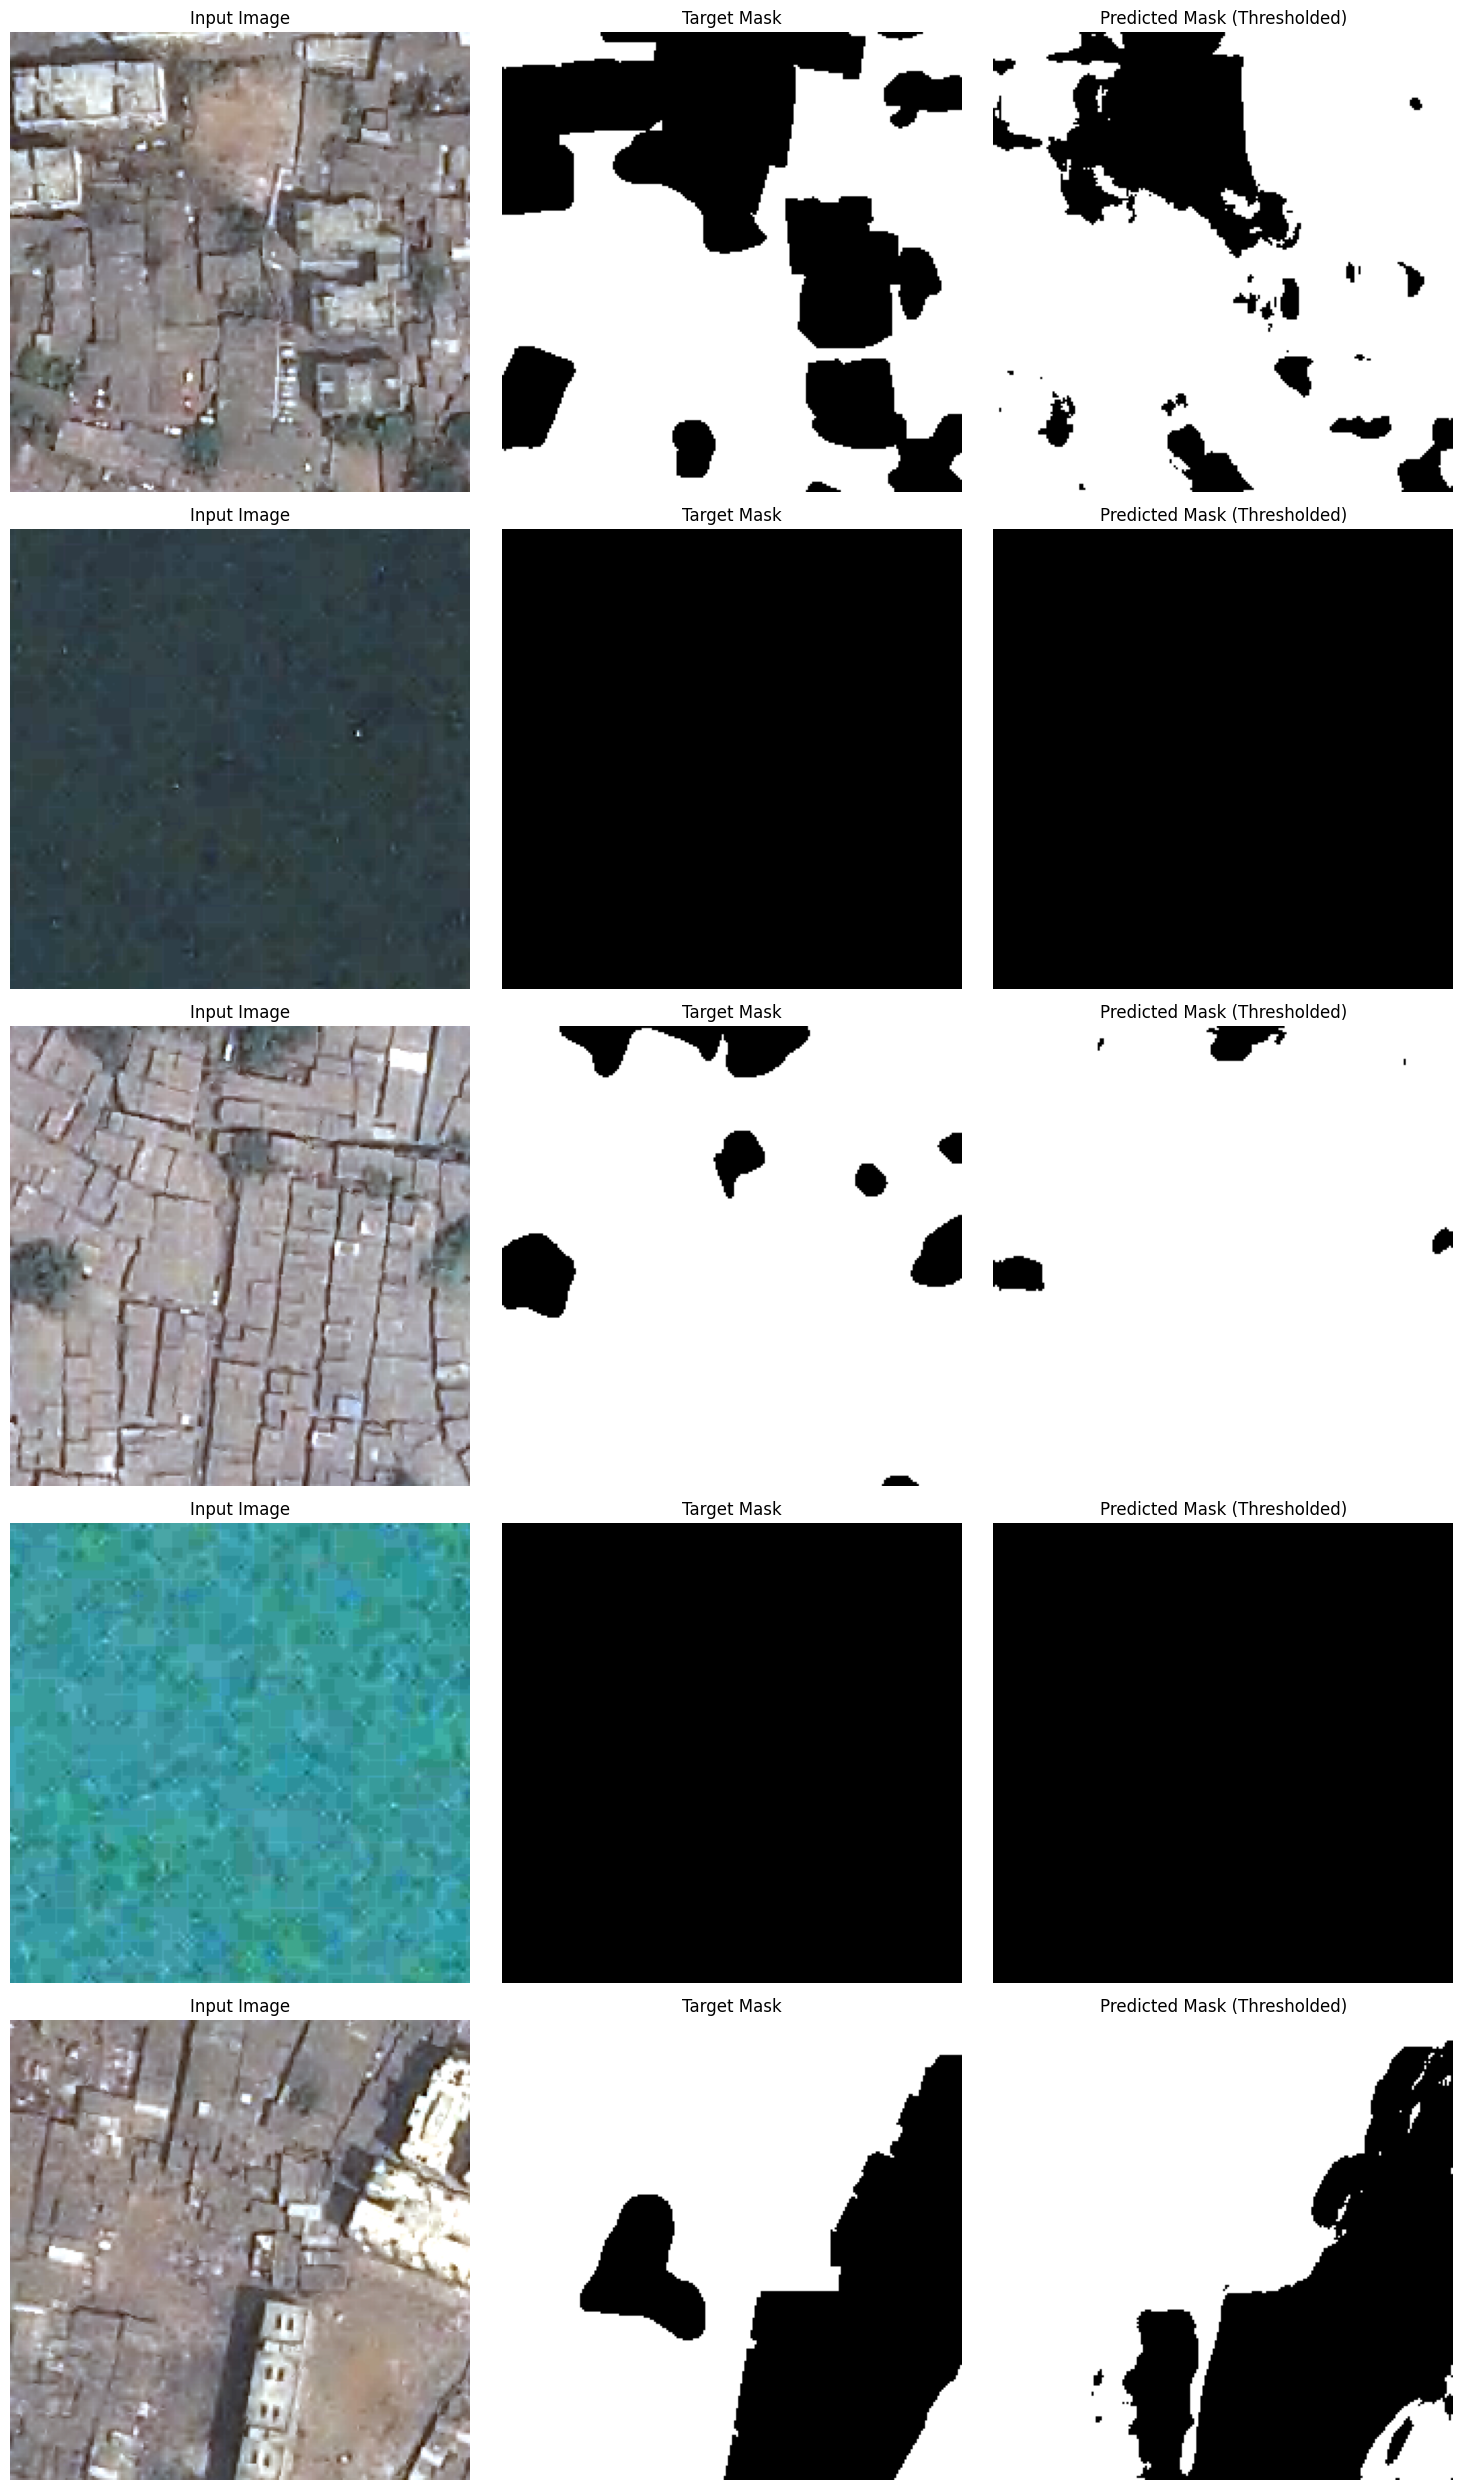

In [ ]:
visualize_predictions(model, dataset, device, num_samples=5)

In [ ]:
import os

def count_files_in_directory(directory_path):
    # Get all files in the directory (excluding subdirectories)
    total_files = sum(1 for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f)))
    return total_files

# Example usage
directory_path = "/content/drive/MyDrive/FYP/UNet/NewSplits/Airbus/test/Masks"
total_files = count_files_in_directory(directory_path)
print(f"Total number of files: {total_files}")

Total number of files: 792
